<a href="https://colab.research.google.com/github/aborbala/tree-canopy/blob/main/01_01_Mask_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Tree Canopy Mask Data Processing Pipeline

A comprehensive geospatial analysis and data preparation workflow for tree canopy
mapping in Berlin. This notebook processes tree cadastral data, performs statistical
analysis on tree properties, generates training masks, and prepares data for machine
learning applications.

Overview:
    This pipeline ingests tree point data from Berlin's cadastral records, performs
    exploratory data analysis, creates predictive models for missing tree attributes,
    generates spatial buffers for tree crowns, and distributes tree points across
    raster tiles for downstream processing.

Main Sections:
    
    1. Setup & Configuration
       - Mount Google Drive and install dependencies
       - Configure visualization theme with Montserrat font
       - Define project paths and area of interest (AOI)
    
    2. Data Loading & Merging
       - Load two tree datasets: Anlagebäume (park trees) and Straßenbäume (street trees)
       - Merge datasets with schema reconciliation
       - Clip trees to the AOI using raster extent boundaries
    
    3. Exploratory Data Analysis
       - Analyze relationship between crown diameter (kronedurch) and tree height (baumhoehe)
       - Visualize distributions with scatter plots
       - Compare cadaster data against reference models
    
    4. Statistical Modeling
       - Fit linear regression model (crown diameter vs. height)
       - Develop polynomial regression (degree 2) for improved predictions
       - Compare against Popescu & Wynne deciduous reference model
       - Calculate R² goodness-of-fit metrics
    
    5. Data Enhancement & Imputation
       - Predict missing crown diameter values using fitted polynomial model
       - Assign default buffer radius (5m) for trees with incomplete data
       - Ensure all numeric columns are properly converted
    
    6. Spatial Buffer Generation
       - Create circular buffers around tree points based on crown diameter
       - Generate both individual tree buffers and dissolved (merged) buffers
       - Add 2m neighborhood buffer to dissolved geometries
       - Export buffered geometries as GeoPackage format
    
    7. Raster Tile Distribution
       - Iterate through raster tiles (sliced imagery)
       - Clip tree points to individual tile boundaries
       - Export clipped points as GeoJSON files per tile
       - Skip tiles with no intersecting tree points

Key Data:
    - Input: Berlin tree cadastral records (Anlagebäume, Straßenbäume)
    - Processing: Tree points with attributes (height, crown diameter, location)
    - Output: 
        * Buffered tree masks (GPKG format)
        * Per-tile tree point distributions (GeoJSON format)
        * Statistical analysis and regression models

CRS:
    - EPSG:25833 (UTM Zone 33N) - Standard for Berlin/Germany region
    - Automatic CRS detection and reprojection included

Dependencies:
    - geopandas, rasterio, shapely (spatial operations)
    - pandas, numpy (data manipulation)
    - scikit-learn (regression modeling)
    - matplotlib, seaborn, plotnine (visualization)

Output Locations:
    - {base_drive}/trees.gpkg - Whole Berlin tree dataset
    - {base_drive}/{aoi_code}/trees.gpkg - AOI tree dataset
    - {base_drive}/{aoi_code}/cadaster_buffered.gpkg - Individual tree buffers
    - {base_drive}/{aoi_code}/cadaster_mask.gpkg - Dissolved/merged buffers
    - {base_drive}/{aoi_code}/cadaster_points/ - Per-tile GeoJSON distributions

"""

# --- Setup ---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install plotnine

In [3]:
!pip install geopandas rasterio shapely

In [4]:
import os
import shutil
from shapely.geometry import Point

In [ ]:
# Remove any previously installed Montserrat fonts
!rm -rf /usr/share/fonts/truetype/montserrat

# Create Montserrat directory
!mkdir -p /usr/share/fonts/truetype/montserrat

# Download Montserrat Regular & Bold
!wget -O /usr/share/fonts/truetype/montserrat/Montserrat-Regular.ttf "https://github.com/JulietaUla/Montserrat/raw/master/fonts/ttf/Montserrat-Regular.ttf"

# Refresh font cache
!fc-cache -fv

--2025-11-24 17:38:32--  https://github.com/JulietaUla/Montserrat/raw/master/fonts/ttf/Montserrat-Regular.ttf
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JulietaUla/Montserrat/master/fonts/ttf/Montserrat-Regular.ttf [following]
--2025-11-24 17:38:32--  https://raw.githubusercontent.com/JulietaUla/Montserrat/master/fonts/ttf/Montserrat-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 445928 (435K) [application/octet-stream]
Saving to: ‘/usr/share/fonts/truetype/montserrat/Montserrat-Regular.ttf’

/usr/share/fonts/tr 100%[===================>] 435.48K  --.-KB/s    in 0.04s   

2025-

In [6]:
# Remove the Matplotlib font cache folder
!rm -rf ~/.cache/matplotlib
# RESTART KERNEL

In [ ]:
from google.colab import drive
import geopandas as gpd
import pandas as pd
from plotnine import ggplot, aes, geom_point, geom_smooth, labs, theme_minimal
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import rasterio
from shapely.geometry import box
import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
montserrat_regular = "/usr/share/fonts/truetype/montserrat/Montserrat-Regular.ttf"
montserrat_font = fm.FontProperties(fname=montserrat_regular)

Loaded Font Name: Montserrat


In [ ]:
all_fonts = fm.findSystemFonts()
print(f"Total Installed Fonts: {len(all_fonts)}")

# Check if Montserrat is in the list
montserrat_fonts = [font for font in all_fonts if "Montserrat" in font]
print("Found Montserrat Fonts:", montserrat_fonts)

Total Installed Fonts: 18
Found Montserrat Fonts: ['/usr/share/fonts/truetype/montserrat/Montserrat-Regular.ttf']


In [ ]:
# Set the theme similar to hrbrthemes::theme_ipsum_rc()
sns.set_style("white") 
plt.rcParams["font.family"] = montserrat_font.get_name()

plt.rcParams.update({
    "axes.grid": False,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titleweight": "bold",
    "axes.titlepad": 10,
    "xtick.major.pad": 5,
    "ytick.major.pad": 5,
})

# --- Configuration ---

In [ ]:
# Define output path
aoi_code = '386_5818' # training data
#aoi_code = '384_5816' # test data

base_drive = '/content/drive/My Drive/masterthesis/data'

# Whole Berlin
anlagebaeume_path = f"{base_drive}/anlagebaume.geojson"
strassenbaeume_path = f"{base_drive}/strassenbaume.geojson"
output_BERLIN_gpkg_path = f"{base_drive}/trees.gpkg"

# AOI
output_AOI_gpkg_path = f"{base_drive}/{aoi_code}/trees.gpkg"
dop_aoi_path = f'{base_drive}/raw/DOP/2020/truedop20cir_{aoi_code}_2_be_2020.tif'
cadaster_dissolved_path = f"{base_drive}/{aoi_code}/cadaster_mask.gpkg"
cadaster_singles_path = f"{base_drive}/{aoi_code}/cadaster_buffered.gpkg"

In [13]:
# Read GeoPackages
anlagebaeume = gpd.read_file(anlagebaeume_path)
strassenbaeume = gpd.read_file(strassenbaeume_path)

# Check if schemas match
if list(anlagebaeume.columns) == list(strassenbaeume.columns):
    trees_berlin_df = gpd.GeoDataFrame(pd.concat([anlagebaeume, strassenbaeume], ignore_index=True))
else:
    # Find common columns
    common_columns = list(set(anlagebaeume.columns) & set(strassenbaeume.columns))
    trees_berlin_df = gpd.GeoDataFrame(pd.concat([anlagebaeume[common_columns], strassenbaeume[common_columns]], ignore_index=True))

In [14]:
trees_berlin_df.head()

,art_bot,kennzeich,standalter,gisid,pitid,eigentuemer,standortnr,gattung_deutsch,namenr,bezirk,kronedurch,pflanzjahr,art_gruppe,gattung,geometry,baumhoehe,art_dtsch,stammumfg
0,Crataegus monogyna,411.232,36.0,00008100_000be4d0,00008100:000be4d0,Land Berlin,066,WEIßDORN,Weigandufer,Neukölln,NaN,1989,Laubbäume,CRATAEGUS,POINT (394621.783 5815731.41),NaN,Eingriffliger Weissdorn,60.0
1,Crataegus crus-galli,411.232,31.0,00008100_000be4d2,00008100:000be4d2,Land Berlin,059,WEIßDORN,Weigandufer,Neukölln,NaN,1994,Laubbäume,CRATAEGUS,POINT (394660.283 5815777.205),NaN,Hahnensporn-Weissdorn,37.0
2,Crataegus prunifolia,411.232,38.0,00008100_000be4f2,00008100:000be4f2,Land Berlin,062,WEIßDORN,Weigandufer,Neukölln,NaN,1987,Laubbäume,CRATAEGUS,POINT (394643.319 5815756.32),NaN,Pflaumenblättriger Weiss-Dorn,65.0
3,Aesculus hippocastanum,221.068,40.0,00008100_000bf296,00008100:000bf296,Land Berlin,14,ROSSKASTANIE,Roetepfuhl-Grünanlage,Neukölln,NaN,1985,Laubbäume,AESCULUS,POINT (393199.923 5811316.447),NaN,Gemeine Rosskastanie,128.0
4,Aesculus hippocastanum,221.068,40.0,00008100_000bf297,00008100:000bf297,Land Berlin,13,ROSSKASTANIE,Roetepfuhl-Grünanlage,Neukölln,NaN,1985,Laubbäume,AESCULUS,POINT (393205.164 5811322.008),NaN,Gemeine Rosskastanie,112.0


In [ ]:
# Export trees for the whole city
trees_berlin_df.to_file(output_BERLIN_gpkg_path, driver="GPKG")

In [ ]:
with rasterio.open(dop_aoi_path) as src:
    bounds = src.bounds
    raster_crs = src.crs

# Create bounding box from raster extent
bbox = box(bounds.left, bounds.bottom, bounds.right, bounds.top)
bbox_gdf = gpd.GeoDataFrame({"geometry": [bbox]}, crs=raster_crs)

# Reproject tree data to match raster CRS
if trees_berlin_df.crs != bbox_gdf.crs:
    trees_berlin_df = trees_berlin_df.to_crs(bbox_gdf.crs)

# Clip using intersection
trees_df = gpd.overlay(trees_berlin_df, bbox_gdf, how='intersection')

In [17]:
trees_df.head()

,art_bot,kennzeich,standalter,gisid,pitid,eigentuemer,standortnr,gattung_deutsch,namenr,bezirk,kronedurch,pflanzjahr,art_gruppe,gattung,baumhoehe,art_dtsch,stammumfg,geometry
0,Betula utilis var. jacquemontii 'Doorenbos',00155,42.0,00008100_000d61ee,00008100:000d61ee,Land Berlin,17,BIRKE,Steinplatz - Grünanlage,Charlottenburg-Wilmersdorf,2.0,1983,Laubbäume,BETULA,6.0,Weißrindige Himalaja-Birke,19.0,POINT (386359.166 5818965.753)
1,Acer platanoides,00155,37.0,00008100_000d61f6,00008100:000d61f6,Land Berlin,1,AHORN,Steinplatz - Grünanlage,Charlottenburg-Wilmersdorf,10.0,1988,Laubbäume,ACER,10.0,Spitz-Ahorn,342.0,POINT (386377.21 5818912.513)
2,Acer saccharinum,00148,68.0,00008100_000d6234,00008100:000d6234,Land Berlin,143,AHORN,Einsteinufer - Grünanlage,Charlottenburg-Wilmersdorf,NaN,1957,Laubbäume,ACER,12.0,Silber-Ahorn,103.0,POINT (386135.602 5819971.932)
3,Ulmus laevis,00148,NaN,00008100_000d6235,00008100:000d6235,Land Berlin,140,ULME,Einsteinufer - Grünanlage,Charlottenburg-Wilmersdorf,NaN,None,Laubbäume,ULMUS,12.0,Flatter-Ulme,180.0,POINT (386152.663 5819960.139)
4,Acer saccharinum,00148,NaN,00008100_000d6236,00008100:000d6236,Land Berlin,139,AHORN,Einsteinufer - Grünanlage,Charlottenburg-Wilmersdorf,NaN,None,Laubbäume,ACER,17.0,Silber-Ahorn,140.0,POINT (386153.007 5819959.448)


In [ ]:
# Only AOI
# Write to GeoPackage
trees_df.to_file(output_AOI_gpkg_path, driver="GPKG")

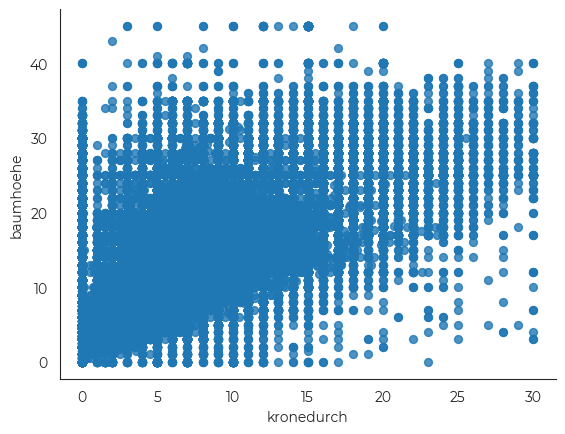

In [ ]:
# @title kronedurch vs baumhoehe
trees_berlin_df.plot(kind='scatter', x='kronedurch', y='baumhoehe', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

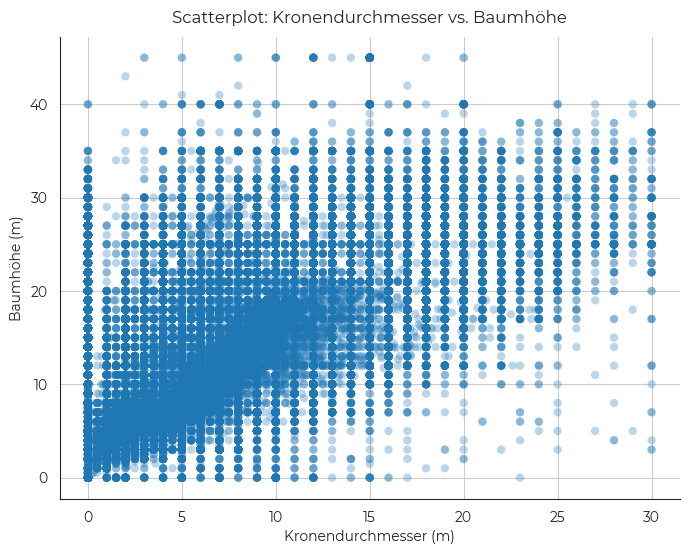

In [19]:
plt.figure(figsize=(8, 6))
plt.scatter(trees_berlin_df['kronedurch'], trees_berlin_df['baumhoehe'], alpha=0.3, edgecolors='none')
plt.xlabel('Kronendurchmesser (m)')
plt.ylabel('Baumhöhe (m)')
plt.title('Scatterplot: Kronendurchmesser vs. Baumhöhe')
plt.grid(True)
plt.show()

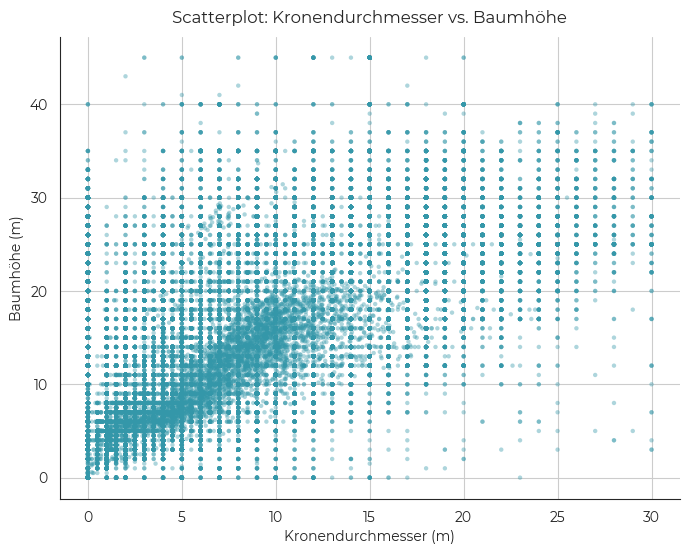

In [ ]:
# Choose a single color from the 'mako' palette
mako_color = sns.color_palette("mako", n_colors=4)[2]

# Plot with smaller point size (e.g., s=10)
plt.figure(figsize=(8, 6))
plt.scatter(trees_berlin_df['kronedurch'], trees_berlin_df['baumhoehe'],
            color=mako_color, s=10, alpha=0.4, edgecolors='none')

plt.xlabel('Kronendurchmesser (m)')
plt.ylabel('Baumhöhe (m)')
plt.title('Scatterplot: Kronendurchmesser vs. Baumhöhe')
plt.grid(True)
plt.show()


In [22]:
# Ensure numerical values
merged_df = trees_berlin_df[['kronedurch', 'baumhoehe']].dropna()
merged_df = merged_df.astype(float)

# Fit linear regression model
X = merged_df[['kronedurch']].values.reshape(-1, 1)
y = merged_df['baumhoehe'].values

model = LinearRegression()
model.fit(X, y)

# Predict values for the regression line
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred = model.predict(X_range)


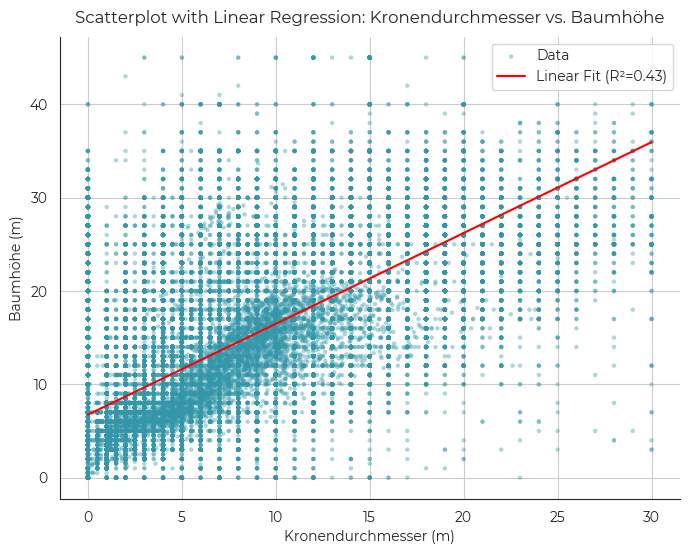

In [23]:
# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=merged_df['kronedurch'], y=merged_df['baumhoehe'],
                color=mako_color, alpha=0.4, edgecolor='none', s=10, label='Data')
plt.plot(X_range, y_pred, color='red', label=f'Linear Fit (R²={model.score(X, y):.2f})')

plt.xlabel('Kronendurchmesser (m)')
plt.ylabel('Baumhöhe (m)')
plt.title('Scatterplot with Linear Regression: Kronendurchmesser vs. Baumhöhe')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Polynomial degree
degree = 2

# Define the function ws_deciduous from the literature
def ws_deciduous(H):
    return 3.09632 + 0.00895 * (H ** 2)

# Polynomial regression model
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_model.fit(X, y)

# Predict values
y_poly_pred = poly_model.predict(X_range)

y_ws_deciduous = ws_deciduous(X_range)

r_squared = poly_model.score(X, y)



/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


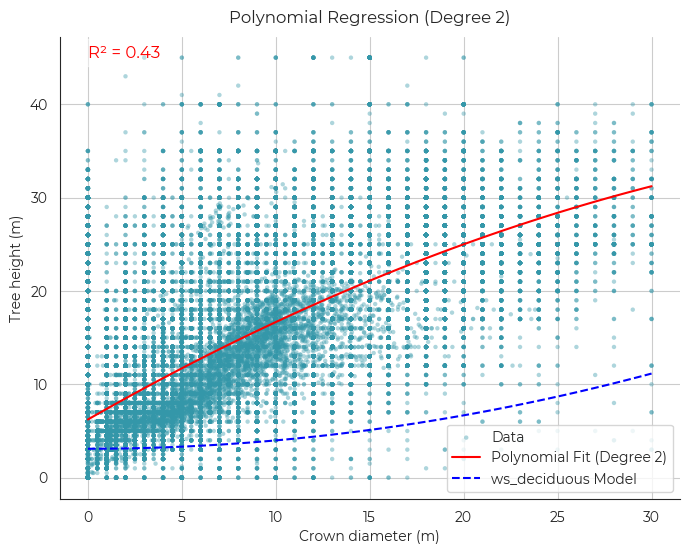

(array([ 0.        ,  1.14945233, -0.0105444 ]), np.float64(6.229898104568687))

In [ ]:
# Scatter plot with polynomial regression curve
plt.figure(figsize=(8, 6))
sns.scatterplot(x=merged_df['kronedurch'], y=merged_df['baumhoehe'],
                color=mako_color, alpha=0.4, edgecolor='none', s=10, label='Data')
plt.plot(X_range, y_poly_pred, color='red', label=f'Polynomial Fit (Degree {degree})')
plt.plot(X_range, y_ws_deciduous, color='blue', linestyle='dashed', label='ws_deciduous Model')
plt.text(X.min(), y.max(), f'R² = {r_squared:.2f}', fontsize=12, color='red', bbox=dict(facecolor='white', alpha=0.5))
plt.xlabel('Crown diameter (m)')
plt.ylabel('Tree height (m)')
plt.title(f'Polynomial Regression (Degree {degree})')
plt.legend()
plt.grid(True)
plt.show()

# Return model coefficients
poly_model.named_steps['linearregression'].coef_, poly_model.named_steps['linearregression'].intercept_

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


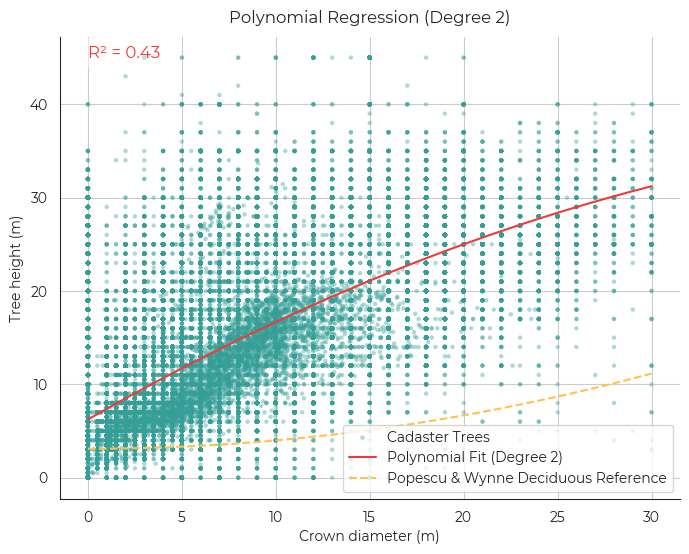

In [ ]:
# Prettify chart

# Define colors
dots_color = '#349E97'
poly_line_color = '#EC3C3A'
ws_line_color = '#FFC24B'

# Scatter plot with polynomial regression curve
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=merged_df['kronedurch'],
    y=merged_df['baumhoehe'],
    color=dots_color,
    alpha=0.4,
    edgecolor='none',
    s=10,
    label='Cadaster Trees'  # Renamed
)

plt.plot(
    X_range,
    y_poly_pred,
    color=poly_line_color,
    label=f'Polynomial Fit (Degree {degree})' # Renamed/Kept clear
)

plt.plot(
    X_range,
    y_ws_deciduous,
    color=ws_line_color,
    linestyle='dashed',
    label='Popescu & Wynne Deciduous Reference' # Renamed
)

plt.text(
    X.min(),
    y.max(),
    f'R² = {r_squared:.2f}',
    fontsize=12,
    color=poly_line_color,
    bbox=dict(facecolor='white', alpha=0.5)
)

plt.xlabel('Crown diameter (m)')
plt.ylabel('Tree height (m)')
plt.title(f'Polynomial Regression (Degree {degree})')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
trees_df.columns

Index(['eigentuemer', 'namenr', 'baumhoehe', 'gisid', 'pitid', 'kronedurch',
       'art_dtsch', 'kennzeich', 'gattung', 'standalter', 'stammumfg',
       'standortnr', 'bezirk', 'art_bot', 'gattung_deutsch', 'art_gruppe',
       'pflanzjahr', 'geometry'],
      dtype='object')

In [ ]:
# Create buffers based on crown size
# Ensure kronedurch and baumhoehe are numeric
trees_df['kronedurch'] = pd.to_numeric(trees_df['kronedurch'], errors='coerce')
trees_df['baumhoehe'] = pd.to_numeric(trees_df['baumhoehe'], errors='coerce')

# Identify missing crown diameter values but with existing height
missing_kronedurch_mask = trees_df['kronedurch'].isna() & trees_df['baumhoehe'].notna()

# Predict missing crowns using the fitted polynomial model
if missing_kronedurch_mask.any():
    X_missing = trees_df.loc[missing_kronedurch_mask, ['baumhoehe']].values.reshape(-1, 1)
    trees_df.loc[missing_kronedurch_mask, 'kronedurch'] = poly_model.predict(X_missing)

# Assign a default radius for trees missing both baumhoehe and kronedurch
trees_df['buffer_radius'] = np.where(
    trees_df['kronedurch'].notna(), trees_df['kronedurch'] / 2,  # Use crown diameter if available
    5  # Default to 5m if no height info
)

# Create buffer geometries
trees_df['geometry'] = trees_df.geometry.buffer(trees_df['buffer_radius'])
buffered_gdf = gpd.GeoDataFrame(trees_df, geometry='geometry', crs=trees_df.crs)

In [ ]:
buffered_gdf.select_dtypes(include=['geometry']).columns

Index(['geometry'], dtype='object')

In [ ]:
buffered_gdf.to_file(cadaster_singles_path, driver="GPKG")

In [ ]:
# Create dissolved buffer file
dissolved_mask = buffered_gdf.dissolve()

# Add 2m buffer to include more context of the neighborhood
dissolved_mask['geometry'] = dissolved_mask.geometry.buffer(2)

# Save to a new file (optional)
dissolved_mask.to_file(cadaster_dissolved_path, driver="GPKG")

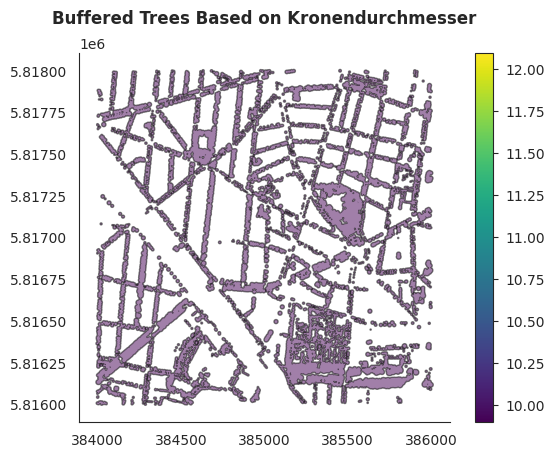

In [ ]:
# Show result
dissolved_mask.plot(column='kronedurch', cmap='viridis', alpha=0.5, edgecolor='black', legend=True)
plt.title("Buffered Trees Based on Kronendurchmesser")
plt.show()

In [ ]:
# Clip files per raster tile

raster_dir = f'{base_drive}/{aoi_code}/sliced_imgs_2020S'
output_dir = f'{base_drive}/{aoi_code}/cadaster_points'

# Create output folder if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

trees_gdf = gpd.GeoDataFrame(trees_df, geometry='geometry', crs='EPSG:25833')

# Loop over raster files
for filename in os.listdir(raster_dir):
    if not filename.lower().endswith('.tif'):
        continue

    raster_path = os.path.join(raster_dir, filename)

    # Open raster and get its bounding box
    with rasterio.open(raster_path) as src:
        bounds = src.bounds
        raster_crs = 'EPSG:25833'

    # Create bounding box geometry
    tile_extent = box(bounds.left, bounds.bottom, bounds.right, bounds.top)
    extent_gdf = gpd.GeoDataFrame({'geometry': [tile_extent]}, crs=raster_crs)
    if trees_gdf.crs != raster_crs:
        trees_gdf = trees_gdf.to_crs(raster_crs)

    # Clip points to tile extent
    points_clipped = gpd.overlay(trees_gdf, extent_gdf, how='intersection')

    # If no points, skip writing
    if points_clipped.empty:
        continue

    output_filename = filename.replace('.tif', '.geojson')
    output_path = os.path.join(output_dir, output_filename)
    points_clipped.to_file(output_path, driver='GeoJSON')

print("Tree point splitting completed.")

✅ Tree point splitting completed.
